In "4.frame_rotation.ipynb" we computed principal angles across layers and the dimension using Matrix theory and Marchenko-Pastur distribution.

Now we move on and evaluate the amount of space our buffer explores during the transformation, we will use different types of metrics.

In [1]:
from transformers import pipeline
import torch
from transformers import AutoModel, AutoTokenizer, AutoModelForCausalLM
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import pandas as pd
import random
import ipywidgets as widgets
from IPython.display import display
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS


In [2]:
#model = AutoModel.from_pretrained( "gpt2", output_hidden_states=True)  #load pretrained from Hugging Face
model = AutoModelForCausalLM.from_pretrained("gpt2", output_attentions=True, output_hidden_states=True)
tokenizer = AutoTokenizer.from_pretrained("gpt2")                     #trasforma input in token

model.eval()    # Set to evaluation mode: Turns off dropout, ensuring deterministic outputs; Freezes running statistics (in LayerNorm).

c:\Users\angel\Desktop\LCP_B_GPT2\.venv\Lib\site-packages\transformers\generation\configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(
c:\Users\angel\Desktop\LCP_B_GPT2\.venv\Lib\site-packages\transformers\generation\configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [3]:
prompts = {
    "vvshort": [
        "She reached out, voice trembling",
        "The data showed unexpected trends",
        "The dough was almost ready",
        "Once upon a",
        "Breaking news interrupted the broadcast"
    ],
    "short": [
        "He glanced back one last time before disappearing into the night, the weight of secrets heavier than his coat",
        "The sauce bubbled gently, filling the kitchen with aroma, but just as she reached for the salt, the phone",
        "The ball soared through the air, curving perfectly toward the goal, but a sudden shout from the sidelines caused",
        "Reports came in from the scene, chaotic and conflicting, as the anchor struggled to piece together what was",
        "Preliminary results contradicted the initial hypothesis, forcing the team to reconsider their approach just as funding approval"
    ],
    "medium": [
        "The street was slick with rain, neon reflections shimmering in puddles. Marcus pulled his jacket tighter, each step echoing in the empty alley. His phone vibrated—an unknown number flashing urgently. He hesitated before answering, voice low. “We don’t have much time,” whispered the voice on the other end, distorted by static. A shadow moved at the edge of the streetlight. He swallowed, heart racing. “Where are you?” The reply came too late. The line went dead, and behind him, the footsteps quickened, closing in. He turned, but the street was empty—except for a single, glinting",
        "Simmering softly on the stove, the broth released a heady mix of herbs and spices, each scent weaving into the other like a well-rehearsed symphony. Julia checked the recipe one more time, making sure she hadn’t missed the crucial step about timing. The stew was nearly perfect, but the texture felt off. She reached for the wooden spoon and tasted a small spoonful—too salty. Frustration prickled at her skin. As she considered adding water, the doorbell rang sharply, breaking her concentration. She wiped her hands on the towel and moved toward the",
        "The stadium roared as the players lined up for the final quarter. Jake’s muscles burned with exhaustion, but adrenaline surged through him as the coach shouted instructions from the sidelines. The score was tied, and every pass, every sprint counted. Sweat stung his eyes, and he could hear his teammates’ breaths coming in ragged gasps. As the ball came flying toward him, he braced for the tackle, the world narrowing to a single moment—one chance to change the game forever. He lunged forward, but the whistle blew just",
        "The breaking story unfolded rapidly, with initial reports describing a massive fire downtown. Eyewitnesses spoke of thick smoke and panicked crowds fleeing the area. Emergency services rushed to the scene, but details remained scarce and contradictory. The news desk scrambled to verify sources as the situation evolved by the minute. Live footage showed flames licking the side of a high-rise, while reporters prepared to go live. Suddenly, the feed cut out, leaving viewers wondering what had happened next—and whether anyone was",
        "The lab was unusually quiet as Dr. Patel stared at the computer screen, the latest batch of data flashing across in graphs and charts. The experiment, designed to track cellular regeneration, was yielding results that defied expectations. Some samples showed accelerated growth, while others appeared to degrade unexpectedly. The team gathered around, debating theories and questioning protocols. A critical variable had to be missing, but what? Before they could decide on the next steps, the phone rang. The voice on the other end delivered news that would force the project into a"
    ],
    "long": [
        "Elena walked through the park as dusk settled, the fading light casting long shadows between the trees. The air smelled faintly of pine and wet earth, and the occasional chirp of a bird punctuated the quiet. She carried a small box, wrapped in brown paper, cradled like a fragile secret. It wasn’t just a gift—it was a piece of her past she wasn’t sure she was ready to confront. The last message she received had been cryptic, a single line: “Meet me where it all began.” As she approached the old bench by the fountain, memories flooded back—laughter, tears, promises whispered under starlit skies. She hesitated, heartbeat quickening. The park seemed empty, but she could feel eyes watching her. The wind picked up, scattering leaves across the path, and in the distance, a dog barked twice. Then a figure emerged from the shadows, stepping forward slowly, and just as Elena opened her mouth to speak, a sudden sound shattered the moment—someone was running toward them, breathless, with news that would change everything and leave no room for mistakes or",
        "The kitchen was warm, redolent with the mingling aromas of garlic, rosemary, and simmering tomatoes. Marco stirred the sauce slowly, watching as the colors deepened and thickened into a rich tapestry. He glanced at the clock; the pasta would need to be ready in less than twenty minutes. His grandmother’s voice echoed in his memory: “Patience is the secret ingredient.” He reached for fresh basil, tearing the leaves gently and sprinkling them into the pot. Suddenly, the doorbell rang, sharp and insistent, interrupting the peaceful rhythm. Wiping his hands on his apron, Marco hurried to the door, wondering who could be visiting at this hour. As he opened it, a familiar face greeted him with a hesitant smile—and in that moment, he realized that tonight’s meal would be about more than just food. But before he could invite the guest in, a crash sounded from the kitchen, and Marco turned back to find the sauce boiling over, spilling across the stove and threatening to ruin everything he had been working toward",
        "The final seconds of the championship game ticked down as the crowd rose to its feet, a tidal wave of noise and anticipation. Sam’s legs pumped hard, lungs burning, eyes locked on the ball as it sailed through the air toward the goal. His teammates shouted encouragement, but the world seemed to narrow to just that ball and the net. Just as he leapt to catch it, a defender collided with him mid-air, sending them both crashing to the turf. Pain exploded in his shoulder, but adrenaline kept him moving. The referee’s whistle was barely audible over the roar, and the scoreboard blinked: tied. As Sam struggled to rise, his coach’s voice cut through the chaos, commanding focus and heart. This was more than a game—it was a battle for pride, a moment that would define their season, and yet, as the clock reset for overtime, a sudden power outage plunged the stadium into darkness, leaving players and fans alike suspended in a breathless",
        "The newsroom buzzed with frantic energy as the evening anchor prepared to go live with the developing story. Earlier that afternoon, a powerful earthquake had struck the coastal city, leaving thousands displaced and critical infrastructure damaged. Eyewitness reports flooded in, some contradicting others, and the station scrambled to verify details while emergency responders raced against time. Satellite images showed the extent of the devastation, while reporters on the ground described scenes of chaos and hope. Families searched for loved ones amidst rubble, and aid organizations mobilized quickly. Just as the anchor began to relay the latest updates, the feed from the disaster zone suddenly cut out, plunging the broadcast into silence. Behind the scenes, technicians worked furiously to restore connection, but the uncertainty deepened as questions arose about the safety of the reporters and the true scope of the catastrophe. And as viewers waited anxiously, the story was far from over, with twists that would test resilience and reveal",
        "In the sterile quiet of the laboratory, Dr. Nguyen adjusted the microscope, focusing on the latest tissue samples that held the key to their breakthrough. Weeks of meticulous work had led to this moment, and the anticipation was palpable. The team gathered, notebooks and tablets at the ready, as images appeared on the screen—cell structures regenerating at rates previously thought impossible. Yet inconsistencies remained: some samples behaved unpredictably, hinting at unknown variables influencing the results. Hypotheses were exchanged, experimental procedures questioned, and plans laid out for further testing. Suddenly, a call came from the ethics board, bringing news of new regulations that threatened to delay the research indefinitely. Faced with bureaucratic obstacles and scientific uncertainty, the team had to decide whether to push forward or risk losing the momentum they had fought so hard to build. And just as they prepared to submit their next report, a startling anomaly in the data suggested that the real discovery might lie"
    ],
    "very_long": [
        "Elena had always believed the past was best left buried, but that evening in the park made her question everything she thought she knew. The bench by the old fountain—worn and cracked from years of weather—held the memories she’d tried to forget. It was the place where laughter once filled the air, where promises had been whispered beneath the stars, and where goodbyes had shattered her world. She stood there now, the small box in her hands feeling heavier than it should, the wrapped contents inside a secret she hadn’t dared to confront. Her phone buzzed again, but this time the screen showed no number, only a blank notification. She glanced around, the shadows deepening under the trees as the city lights flickered on in the distance. The scent of wet earth mixed with faint traces of jasmine, reminding her of summers long past. The park was deserted except for a lone dog barking somewhere beyond the trees, its cry echoing through the quiet. Elena’s heart raced. The figure she had seen earlier, stepping out of the shadows, was nowhere to be found. She tried to convince herself it was just her imagination playing tricks, but the unmistakable feeling of being watched gnawed at her nerves. She unfolded the note she’d found slipped into her coat pocket that morning—a single line written in shaky handwriting: “Meet me where it all began.” She thought about calling her brother, the only other person who knew the story behind the box and what it contained, but the signal was weak here, and the memory of their last fight held her back. The city was changing fast, swallowing old neighborhoods with glass towers and cafés. But this park, this bench, this moment—they were frozen in time, like a snapshot she couldn’t escape. Suddenly, footsteps approached from behind. Elena turned sharply, but before she could say a word, a man’s voice cut through the air. “You shouldn’t be here alone.” It was familiar, yet strained, carrying the weight of unspoken regrets. He stepped forward, hands raised as if to show he meant no harm. “I didn’t expect you,” Elena said, voice trembling. “Why now? After all these years?” He glanced at the box in her hands and then at the bench. “Because the truth doesn’t stay buried forever. You need to know what really happened.” Before she could respond, a sharp noise echoed nearby—the crack of a twig, a sudden rustle of leaves—and both froze. Somewhere in the distance, a siren wailed, piercing the night. The man’s eyes darkened. “They’re coming,” he whispered. “We don’t have much time.” Elena felt the old adrenaline kick in. Memories flooded back: running through these paths as a child, whispered warnings from her parents, secrets hidden beneath layers of silence. She didn’t know who “they” were anymore, or what had changed, but the urgency was unmistakable. She clutched the box tighter, deciding to trust this stranger—for now. Together, they moved quickly through the park, shadows stretching long and twisted, until they reached an iron gate half-covered with ivy. Beyond lay an abandoned building, its windows shattered, and graffiti sprawling over cracked walls. The man fumbled with a key, his hands shaking just slightly. “Inside,” he said, pushing the door open. The stale air hit her like a wall. The room was littered with old furniture and papers scattered across a desk. A single lamp flickered overhead. “There’s something you need to see,” he said, pulling out a worn photograph from his coat. It was a picture of two children standing by this very fountain, their smiles frozen in time. One was Elena, the other a boy she vaguely remembered—a friend she’d lost contact with years ago. As she stared at the photo, a distant memory surfaced—a secret pact made in childhood, a promise never kept. The man’s voice broke her reverie. “It’s all connected. The disappearance, the lies, the people who wanted to erase you from the story.” He paused, eyes searching hers. “But it’s not too late.” Before Elena could respond, a loud crash sounded from above, followed by hurried",
        "The kitchen was alive with the scent of garlic and fresh herbs, the rhythmic chopping of vegetables punctuating the air. Marco worked with practiced hands, his mind a dance between tradition and innovation. Tonight’s dinner was more than a meal—it was a story, a legacy passed down through generations, simmering slowly in the pot on the stove. He glanced at the worn recipe book, its pages yellowed and soft, stained from years of spills and spills. His grandmother’s handwriting curled across the page, each instruction a whisper from the past. “Patience, Marco. The secret is in the simmer.” The tomato sauce bubbled gently, thickening with the addition of fresh basil and a splash of red wine. Marco stirred carefully, making sure not to disturb the delicate balance of flavors. Outside, the sun dipped below the horizon, casting a warm glow through the kitchen window. The pasta was next—a dough made from scratch, rolled thin and cut into wide ribbons. Marco remembered the afternoons spent with his grandmother, flour dusting the countertops and laughter filling the air. “Taste the love,” she had said. He reached for the rolling pin, but just as he began, the doorbell rang sharply, startling him. Wiping his hands, he opened the door to find an unexpected visitor—a friend from childhood, eyes wide with urgency. “Marco, I need your help,” the visitor said, voice low and serious. “It’s about the farm. The harvest is failing.” Concern replaced the warmth in Marco’s chest. The farm was the heart of his family’s livelihood, the source of the ingredients he so carefully selected. “Tell me everything,” he said, stepping aside. The visitor explained how the crops were wilting, plagued by a strange blight that no one could identify. Without a good harvest, the future was uncertain. Marco’s mind raced. Could his grandmother’s knowledge extend beyond the kitchen? Was there a remedy hidden in the recipes, in the herbs, in the traditions? They sat together, poring over old notes and recipes, searching for clues. Marco’s fingers traced the lines about medicinal herbs, the ways of preserving and healing. The kitchen, once a sanctuary, became a laboratory of hope and desperation. Hours passed, and as the moon rose high, Marco prepared a special infusion of herbs and spices, combining flavors with purpose. He hoped the old ways held answers, that this meal could be more than nourishment—that it could be a cure. But as dawn crept in, the scent of the infusion filled the room, mingling with uncertainty and possibility. Outside, the farm awaited, fragile and fading, while inside, Marco faced the question of whether tradition alone could withstand the challenges of the modern world. And just as he prepared to leave with the remedy in hand, a sudden sound from the kitchen made him pause—a crash, a broken jar, and then silence.",
        "The stadium was a sea of noise, a cacophony of cheers and chants that reverberated through every corner. Sam stood at midfield, muscles taut and sweat slick against his skin. The championship game had been a grueling battle, each minute a test of endurance and will. Now, with only seconds left on the clock and the score tied, everything came down to this moment. He could feel the pressure crushing down—fans holding their breath, teammates shouting, and the coach’s voice booming in his ears. His eyes locked on the ball as it arced toward him, a lifeline thrown in the chaos. Time seemed to slow. Leaping, Sam stretched every fiber of his body, hands reaching. The defender came at him hard, and the collision sent them both tumbling to the turf. Pain exploded in his shoulder, but adrenaline carried him forward. He clutched the ball to his chest as the referee’s whistle pierced the air. Tied game. Overtime. The floodlights illuminated the field like stars, but then suddenly, the entire stadium was plunged into darkness. Gasps and murmurs erupted from the crowd. The sudden blackout left players frozen in place, a surreal pause in a battle that had consumed them for hours. Back in the locker room, the team huddled, breaths ragged and hearts pounding. The coach paced, rallying spirits. “This is our chance,” he said, eyes blazing. “Focus, fight, and remember why we started.” Sam sat, ice pack on his shoulder, mind replaying the game’s pivotal moments—the near misses, the saves, the strategy. But doubts crept in. Could they overcome the unexpected? Could they rally when the world seemed to be against them? Outside, technicians scrambled to restore power as fans murmured anxiously. Media crews speculated, and social media exploded with theories and memes. The blackout had become a story within the story, a moment that would be remembered long after the final whistle. And just as the lights flickered back on, a mysterious figure was spotted near the stadium’s entrance, their presence raising questions about whether the blackout was an accident—or something far more deliberate. The game was about to resume, but the tension in the air was thick, and no one could say what would happen next",
        "The newsroom was a whirlwind of activity, phones ringing, screens flashing, and reporters rushing to gather the latest information. Earlier that day, a massive earthquake had struck the coastal city, toppling buildings and sending shockwaves through the region. The devastation was staggering, and emergency services were stretched to their limits. Anchors prepared to go live with breaking updates, but the situation was fluid and confusing. Initial reports varied wildly—some spoke of hundreds trapped beneath rubble, others mentioned fires raging through neighborhoods. Families searched desperately for missing loved ones, while rescue teams battled against time and aftershocks. Live footage showed scenes of chaos: collapsed roads, overturned cars, and crowds gathered in makeshift shelters. Aid organizations mobilized quickly, coordinating efforts with local officials. But amid the urgency, misinformation spread rapidly through social media, complicating efforts to keep the public informed. At the station, producers scrambled to verify sources and piece together a coherent narrative. Interviews with eyewitnesses revealed personal stories of loss and heroism, while experts weighed in on the region’s seismic history and preparedness. Suddenly, the live feed from the disaster zone cut out without warning, plunging the broadcast into silence. Technicians worked feverishly to restore connection, but viewers were left in suspense. Behind the scenes, questions mounted: Were the reporters safe? Was the situation worsening? As the hours passed, the newsroom grappled with how to balance breaking news with responsible reporting. The story was far from over, with implications for infrastructure, politics, and human resilience. Meanwhile, in the field, a young journalist uncovered evidence of a delayed warning system, raising critical questions about accountability. The story was gaining momentum, and what began as a natural disaster was evolving into a complex investigation that would challenge the region’s leaders and redefine the public’s trust. And as the sun set on the first day of the crisis, the world watched—and waited—for answers that were still out of reach",
        "The sterile hum of the laboratory was broken only by the soft clicking of keys and the occasional murmur of voices. Dr. Nguyen leaned closer to the microscope, eyes fixed on the cellular structures that had consumed the team’s focus for months. Their research into regenerative medicine had reached a pivotal stage, with preliminary results hinting at breakthroughs that could revolutionize treatment for a range of diseases. Yet, as the data accumulated, so did the questions. Some cell samples responded positively, showing accelerated healing and growth, while others behaved erratically, defying expectations. The team debated theories, scrutinized protocols, and meticulously documented every variable. “We need to isolate the factor causing the inconsistencies,” Dr. Patel said, pointing to a graph where one batch of samples diverged dramatically from the others. “It could be a contaminant or a genetic anomaly.” Hours slipped by as experiments were repeated and hypotheses refined. The pressure to deliver results was immense—not only for the promise of scientific advancement but also for securing the next round of funding. Ethics reviews and regulatory hurdles loomed on the horizon, complicating the path forward. Suddenly, an alert popped up on the computer screen—a request from the ethics board delaying approval for the next phase due to concerns over experimental procedures. The room fell into uneasy silence. The team knew that without swift approval, months of work could stall indefinitely. Amid this uncertainty, a junior researcher made a startling discovery: an unexpected protein present only in the successful samples. Its properties suggested a previously unknown mechanism for cellular regeneration, but replicating the effect would require redesigning the entire experiment. The lead scientist, Dr. Nguyen, called an emergency meeting. The air was thick with tension as the team weighed the risks and rewards of pivoting their approach. Pushing forward without approval could jeopardize their careers, but halting now might mean losing a chance at a medical revolution. As the debate raged, a sudden phone call from a collaborator overseas brought news of a similar discovery, offering both hope and competition. The scientific race was heating up, and the stakes had never been higher. In the midst of this storm of ambition, ethics, and discovery, the team prepared to make a choice that would define not only their careers but potentially the future of medicine. Yet, just as the decision was about to be finalized, an unexpected anomaly appeared in the data—a pattern so strange it challenged everything they believed. And with that, the research was poised on the edge of a breakthrough—or a collapse"
    ],
}



In [4]:
prompt = prompts["very_long"][0]
inputs = tokenizer(prompt, return_tensors="pt")
input_ids = inputs["input_ids"]
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

print("Tokens:")
for idx, tok in enumerate(tokens):
    print(f"{idx:2}: {tok}")

# Containers for layer outputs
embedding_outputs = []
attention_outputs = []
mlp_outputs = []
ln1_outputs = []
ln2_outputs = []

# Hook functions to capture intermediate activations
def get_embedding_output(module, input, output):
    embedding_outputs.append(output.detach())

def get_attention_output(module, input, output):
    attention_outputs.append(output[0].detach())

def get_mlp_output(module, input, output):
    mlp_outputs.append(output.detach())

def get_ln1_output(module, input, output):
    ln1_outputs.append(output.detach())

def get_ln2_output(module, input, output):
    ln2_outputs.append(output.detach())


# Register forward hooks
model.transformer.drop.register_forward_hook(get_embedding_output)
#model.transformer.wpe.register_forward_hook(get_embedding_output)

for block in model.transformer.h:
    block.ln_1.register_forward_hook(get_ln1_output)
    block.attn.register_forward_hook(get_attention_output)
    block.ln_2.register_forward_hook(get_ln2_output)
    block.mlp.register_forward_hook(get_mlp_output)

model.transformer.ln_f.register_forward_hook(get_ln1_output)

# Clear stored outputs before a new forward pass
embedding_outputs.clear()
attention_outputs.clear()
mlp_outputs.clear()
ln1_outputs.clear()
ln2_outputs.clear()

with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits  # Shape: [1, seq_len, vocab_size]
attentions = outputs.attentions  # List of [1, n_heads, seq_len, seq_len]
seq_len=logits.shape[1]

hidden_dim = ln1_outputs[0][0].shape[1]


`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Tokens:
 0: El
 1: ena
 2: Ġhad
 3: Ġalways
 4: Ġbelieved
 5: Ġthe
 6: Ġpast
 7: Ġwas
 8: Ġbest
 9: Ġleft
10: Ġburied
11: ,
12: Ġbut
13: Ġthat
14: Ġevening
15: Ġin
16: Ġthe
17: Ġpark
18: Ġmade
19: Ġher
20: Ġquestion
21: Ġeverything
22: Ġshe
23: Ġthought
24: Ġshe
25: Ġknew
26: .
27: ĠThe
28: Ġbench
29: Ġby
30: Ġthe
31: Ġold
32: Ġfountain
33: âĢĶ
34: worn
35: Ġand
36: Ġcracked
37: Ġfrom
38: Ġyears
39: Ġof
40: Ġweather
41: âĢĶ
42: held
43: Ġthe
44: Ġmemories
45: Ġshe
46: âĢ
47: Ļ
48: d
49: Ġtried
50: Ġto
51: Ġforget
52: .
53: ĠIt
54: Ġwas
55: Ġthe
56: Ġplace
57: Ġwhere
58: Ġlaughter
59: Ġonce
60: Ġfilled
61: Ġthe
62: Ġair
63: ,
64: Ġwhere
65: Ġpromises
66: Ġhad
67: Ġbeen
68: Ġwhispered
69: Ġbeneath
70: Ġthe
71: Ġstars
72: ,
73: Ġand
74: Ġwhere
75: Ġgood
76: by
77: es
78: Ġhad
79: Ġshattered
80: Ġher
81: Ġworld
82: .
83: ĠShe
84: Ġstood
85: Ġthere
86: Ġnow
87: ,
88: Ġthe
89: Ġsmall
90: Ġbox
91: Ġin
92: Ġher
93: Ġhands
94: Ġfeeling
95: Ġheavier
96: Ġthan
97: Ġit
98: Ġshould
99: ,
100: Ġthe


Helper functions for getting principal angles and signal dimensions from Marchenko-Pastur:

In [5]:
def get_signal_dimensions(activations):
    """
    Returns a list of signal subspace dimensions per layer using MP bound.
    """
    signal_dims = []

    for layer_out in activations:
        X = layer_out[0].cpu().numpy()  # [seq_len, hidden_dim]
        X_centered = X - X.mean(axis=0)
        U, S, VT = np.linalg.svd(X_centered, full_matrices=False)
        eigenvalues = (S ** 2) / X.shape[0]

        n_samples, n_features = X.shape
        Q = n_samples / n_features
        sigma2 = np.var(X_centered)

        lambda_max = sigma2 * (1 + np.sqrt(1/Q))**2
        d = np.sum(eigenvalues > lambda_max)
        signal_dims.append(d)

    return signal_dims

def compute_principal_angles(A, B, normalize_total):
    """
    Compute the principal angles between two subspaces A and B using SVD of the cross Gram matrix.
    A, B: np.ndarray with orthonormal columns (shape: [hidden_dim, d])
    Returns:
        cosines of principal angles, angles (in radians), and sum of angles (Θ).
    """
    M = A.T @ B  # Cross Gram matrix
    U, s, Vt = np.linalg.svd(M)  # s are cos(θ_i)
    angles = np.arccos(np.clip(s, -1.0, 1.0))  # Ensure valid range
    total_angle = np.sum(angles)
    
    if normalize_total:
        max_possible_angle = len(angles) * (np.pi / 2)
        total_angle /= max_possible_angle  # Now in [0, 1]
 
    return s, angles, total_angle


normalized=False
# Get signal dimensions
signal_dims = get_signal_dimensions(ln1_outputs)

# Extract signal subspaces
signal_bases = []
for layer_out, d in zip(ln1_outputs, signal_dims):
    X = layer_out[0].cpu().numpy()  # [seq_len, hidden_dim]
    X_centered = X - X.mean(axis=0)
    U, _, _ = np.linalg.svd(X_centered, full_matrices=False)
    basis = U[:, :d]  # Use first d left-singular vectors
    signal_bases.append(basis)

# Compute pairwise principal angles between signal subspaces
angles_between_layers = {}
for i in range(len(signal_bases)):
    for j in range(i+1, len(signal_bases)):
        A = signal_bases[i]
        B = signal_bases[j]
        s, angles, total = compute_principal_angles(A, B, normalized)
        angles_between_layers[(i, j)] = {
            "cosines": s,
            "angles_rad": angles,
            "Θ_total": total
        }

Principal angles quantify how “aligned” or “different” two subspaces are.

Θ = 0° → identical signal subspaces.

Θ large (approaching 90° × d) → highly distinct.

In [6]:
def compute_total_angle_between_outputs(out1, out2):
    """
    Compute total principal angle between two activation outputs using MP-based signal dimensions.
    """
    X1 = out1[0].cpu().numpy()
    X2 = out2[0].cpu().numpy()
    X1_centered = X1 - X1.mean(axis=0)
    X2_centered = X2 - X2.mean(axis=0)

    d1 = get_signal_dimensions([out1])[0]
    d2 = get_signal_dimensions([out2])[0]

    U1, _, _ = np.linalg.svd(X1_centered, full_matrices=False)
    U2, _, _ = np.linalg.svd(X2_centered, full_matrices=False)

    B1 = U1[:, :d1]
    B2 = U2[:, :d2]

    _, _, total_angle = compute_principal_angles(B1, B2, False)
    return np.degrees(total_angle)


## Goal: Measure the "Exploration of Subspace"
- How diverse are the signal subspaces over time (or over data)?
- How much of the ambient space is explored?

In linear algebra terms: how much of the total high-dimensional space is spanned by the collection of signal subspaces?


1. Compute the mean pairwise principal angles. While true Grassmannian volumes are complex to compute, especially in high dimensions, we can approximate "spread" via average orthogonality.

Higher avg_angle → subspaces are more diverse → space is more explored.

Avg Principal Angle (Θ): 338.82°
Max Angle: 1824.05°
Min Angle: 48.79°
Num Layer Pairs: 78


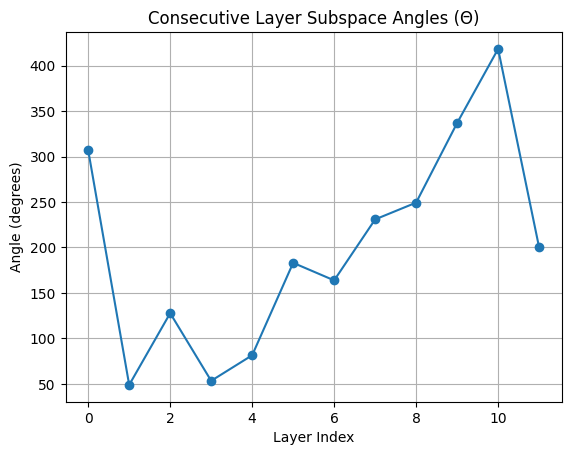

In [7]:
def compute_angle_statistics(angles_between_layers, in_degrees=False):
    all_angles = [info["Θ_total"] for info in angles_between_layers.values()]
    if in_degrees:
        all_angles = [np.degrees(a) for a in all_angles]
    avg_angle = np.mean(all_angles)
    max_angle = np.max(all_angles)
    min_angle = np.min(all_angles)
    return {
        "mean_angle": avg_angle,
        "max_angle": max_angle,
        "min_angle": min_angle,
        "num_pairs": len(all_angles)
    }

def plot_consecutive_layer_angles(signal_bases):
    consecutive_angles = []
    for i in range(len(signal_bases) - 1):
        _, _, theta = compute_principal_angles(signal_bases[i], signal_bases[i+1], normalize_total=False)
        consecutive_angles.append(np.degrees(theta))

    plt.plot(consecutive_angles, marker='o', color='tab:blue')
    plt.title("Consecutive Layer Subspace Angles (Θ)")
    plt.xlabel("Layer Index")
    plt.ylabel("Angle (degrees)")
    plt.grid(True)
    plt.show()

# --- Angle statistics
angle_stats = compute_angle_statistics(angles_between_layers, in_degrees=True)
print(f"Avg Principal Angle (Θ): {angle_stats['mean_angle']:.2f}°")
print(f"Max Angle: {angle_stats['max_angle']:.2f}°")
print(f"Min Angle: {angle_stats['min_angle']:.2f}°")
print(f"Num Layer Pairs: {angle_stats['num_pairs']}")

plot_consecutive_layer_angles(signal_bases)

Since principal angles can reach maximum values of 90° × d, where d is the dimensionality of each subspace, we use a slightly different metric that does not depend on d: 

2. Dispersion Score (Average normalized angle)
This is similar to avg_pairwise_angle, but using normalized total angles

In [8]:
# Build normalized angle dictionary
normalized_angles_between_layers = {}
for i in range(len(signal_bases)):
    for j in range(i + 1, len(signal_bases)):
        A = signal_bases[i]
        B = signal_bases[j]
        _, _, total = compute_principal_angles(A, B, normalize_total=True)
        normalized_angles_between_layers[(i, j)] = {"Θ_total": total}

def compute_dispersion_score(normalized_angle_dict):
    scores = [info["Θ_total"] for info in normalized_angle_dict.values()]
    return np.mean(scores)

dispersion_score = compute_dispersion_score(normalized_angles_between_layers)
print(f"Dispersion score (normalized Θ): {dispersion_score:.3f}")


Dispersion score (normalized Θ): 0.260


The dispersion score ranges from 0 to 1:

0 = all subspaces are identical (no dispersion).

1 = all subspaces are maximally disjoint (orthogonal, completely different directions).

It reflects how spread out or diverse the set of subspaces is in the high-dimensional space.


In a buffer, a higher dispersion score implies:
- The system explores a wider range of directions over time.
- Likely retains less redundancy.
- Can encode more information or capture temporal variation.

A low dispersion score suggests:
- Redundant representations across layers.
- Possibly more stability, but less flexibility.

3. Subspace Overlap

We defined overlap as: Fraction of shared signal directions between layer i and layer j.

In [9]:
def compute_subspace_overlap(A, B, threshold=0.9):
    """
    A, B: [hidden_dim, d] orthonormal bases.
    Return: fraction of principal angles below threshold (in cosine similarity).
    """
    s, _, _ = compute_principal_angles(A, B, normalize_total=False)
    return np.mean(s > threshold)  # higher = more overlap


This function:

- Computes the principal angles between two subspaces (via the singular values s of A.T @ B).
- Returns the fraction of principal angles with cos(θ) > threshold — which corresponds to high similarity.

🔍 Connection to Canonical Correlation Analysis (CCA)
While this is not "full" CCA, it's equivalent to CCA in the special case where A and B are orthonormal bases:

The output of np.linalg.svd(X_centered, full_matrices=False) gives orthonormal left singular vectors in U, if the input is real-valued and well-conditioned.
So if you're slicing U[:, :d], your signal bases should already be orthonormal.

The canonical correlations from CCA equal the singular values from A.T @ B.

Therefore, this overlap metric is a CCA-style subspace similarity score.

This allows us to interpret this as measuring how much the signal subspaces of two layers align geometrically.

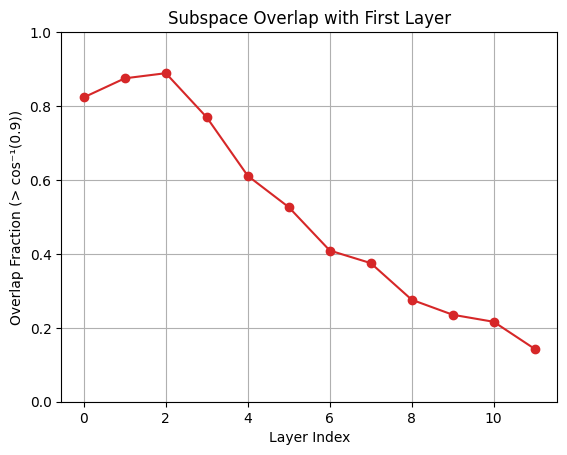

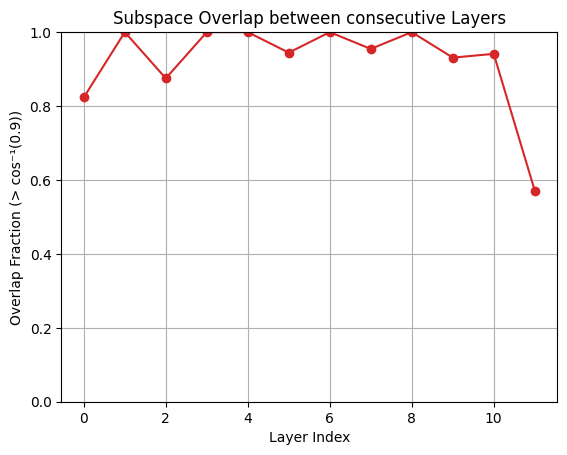

In [10]:
overlaps_with_first = [compute_subspace_overlap(signal_bases[0], signal_bases[i])
                       for i in range(1, len(signal_bases))]

plt.plot(overlaps_with_first, marker='o', color='tab:red')
plt.title("Subspace Overlap with First Layer")
plt.xlabel("Layer Index")
plt.ylabel("Overlap Fraction (> cos⁻¹(0.9))")
plt.ylim(0, 1)
plt.grid(True)
plt.show()


overlaps_consecutive = [compute_subspace_overlap(signal_bases[i], signal_bases[i+1])
                       for i in range(0, len(signal_bases)-1)]

plt.plot(overlaps_consecutive, marker='o', color='tab:red')
plt.title("Subspace Overlap between consecutive Layers")
plt.xlabel("Layer Index")
plt.ylabel("Overlap Fraction (> cos⁻¹(0.9))")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

This tells you how much each later layer still shares the directions of earlier ones, which is a good proxy for "memory" or "repetition."

4. Effective Dimensionality

We compare our results obtained through Mrachenko-pastur test and a simpler PCA retaining 90% of variance.

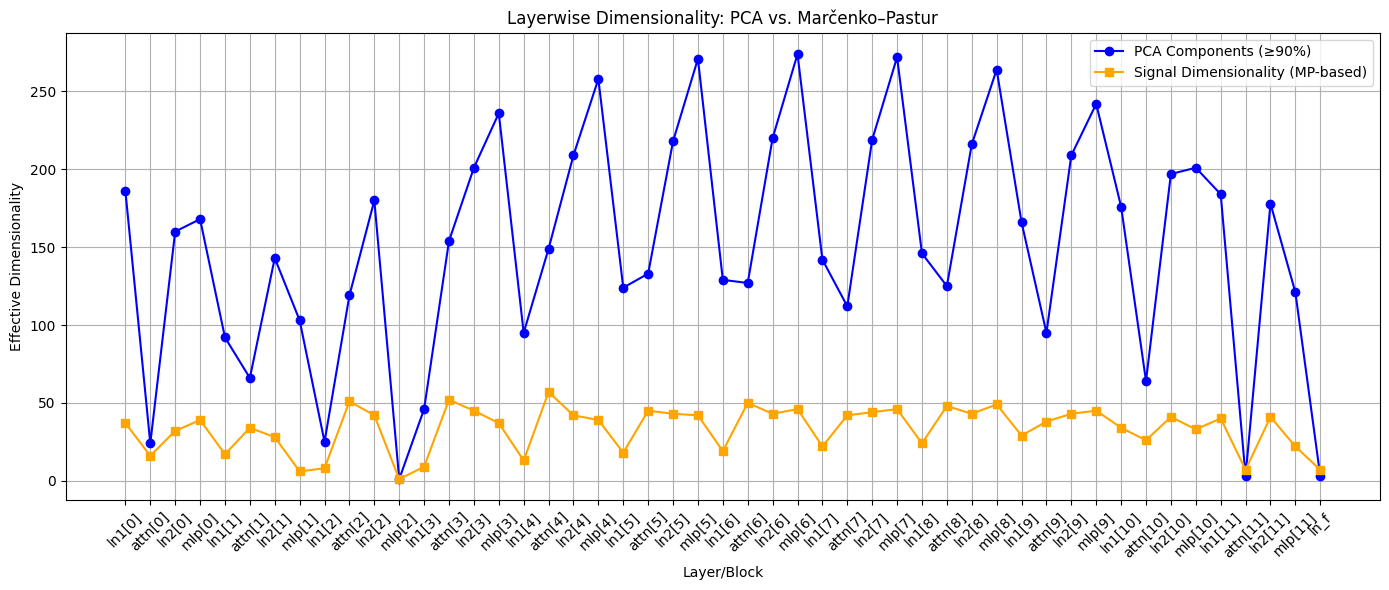

In [11]:
def compute_pca_components(outputs_list, cumulative_threshold=0.9):
    component_counts = []

    for out in outputs_list:
        vecs = out[0].cpu().numpy()  # shape: [seq_len, hidden_dim]
        pca = PCA()
        pca.fit(vecs)
        explained = pca.explained_variance_ratio_
        cumulative = np.cumsum(explained)
        num_components = np.searchsorted(cumulative, cumulative_threshold) + 1
        component_counts.append(num_components)

    return component_counts

# First, compute PCA-based dimensionalities
pca_ln1 = compute_pca_components(ln1_outputs)
pca_attn = compute_pca_components(attention_outputs)
pca_ln2 = compute_pca_components(ln2_outputs)
pca_mlp = compute_pca_components(mlp_outputs)

# Now compute signal dimensionalities using the same function across blocks
signal_ln1 = get_signal_dimensions(ln1_outputs)
signal_attn = get_signal_dimensions(attention_outputs)
signal_ln2 = get_signal_dimensions(ln2_outputs)
signal_mlp = get_signal_dimensions(mlp_outputs)

# Interleave values across blocks for visualization
pca_dims_all = []
signal_dims_all = []
labels = []

for i in range(12):
    pca_dims_all.append(pca_ln1[i])
    signal_dims_all.append(signal_ln1[i])
    labels.append(f"ln1[{i}]")

    pca_dims_all.append(pca_attn[i])
    signal_dims_all.append(signal_attn[i])
    labels.append(f"attn[{i}]")

    pca_dims_all.append(pca_ln2[i])
    signal_dims_all.append(signal_ln2[i])
    labels.append(f"ln2[{i}]")

    pca_dims_all.append(pca_mlp[i])
    signal_dims_all.append(signal_mlp[i])
    labels.append(f"mlp[{i}]")

# Add ln_f
pca_dims_all.append(pca_ln1[12])
signal_dims_all.append(signal_ln1[12])
labels.append("ln_f")

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(pca_dims_all, marker='o', label='PCA Components (≥90%)', color='blue')
plt.plot(signal_dims_all, marker='s', label='Signal Dimensionality (MP-based)', color='orange')

plt.xticks(ticks=range(len(labels)), labels=labels, rotation=45)
#plt.yticks(np.arange(1, seq_len))
plt.title("Layerwise Dimensionality: PCA vs. Marčenko–Pastur")
plt.xlabel("Layer/Block")
plt.ylabel("Effective Dimensionality")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


MP test is much more conservative. This is stressed with longer (1000 tokens) prompts where MP gives always signal dimensionality below 50; however the effective dimensionality is way smaller than the embedding space.

5. Union Subspace Rank (Dimensionality of Combined Subspace)

This measures whether representations in later layers are just linear combinations of earlier ones or they explore new directionsof the embedding space

In [12]:
def compute_union_subspace_rank(signal_bases, tol=1e-6):
    all_bases = np.concatenate(signal_bases, axis=1)  # [hidden_dim, total_d]
    u, s, _ = np.linalg.svd(all_bases, full_matrices=False)
    rank = np.sum(s > tol)
    return rank, s

def compute_cumulative_union_ranks(signal_bases, tol=1e-6):
    """
    Computes the cumulative union subspace rank as we include more layers.
    """
    cumulative_ranks = []
    all_bases = []

    for basis in signal_bases:
        all_bases.append(basis)
        stacked = np.concatenate(all_bases, axis=1)
        u, s, _ = np.linalg.svd(stacked, full_matrices=False)
        rank = np.sum(s > tol)
        cumulative_ranks.append(rank)

    return cumulative_ranks  # length = number of layers

# --- Compute rank of total explored space
union_rank, _ = compute_union_subspace_rank(signal_bases)
print("Union subspace rank:",union_rank, f"({union_rank*100/768}%)")

Union subspace rank: 277 (36.067708333333336%)


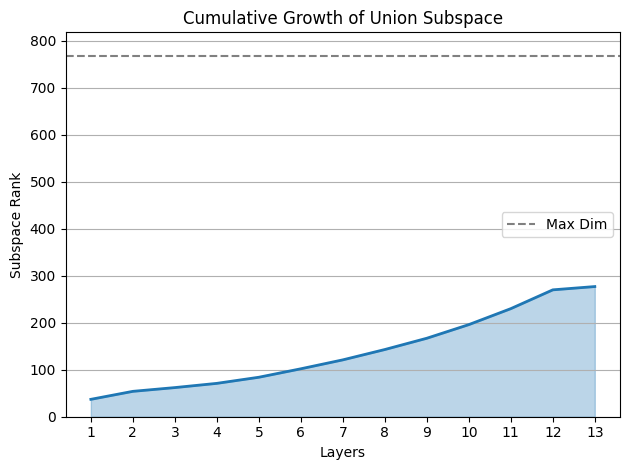

In [13]:
def plot_cumulative_union_growth(cumulative_ranks, hidden_dim):
    num_layers = len(cumulative_ranks)
    layers = np.arange(1, num_layers + 1)

    
    # Line plot of rank growth
    plt.plot(layers, cumulative_ranks, color='tab:blue', linewidth=2)
    
    # Area (saturation)
    plt.fill_between(layers, cumulative_ranks, alpha=0.3, color='tab:blue')
    
    plt.axhline(hidden_dim, linestyle="--", color="gray", label="Max Dim")
    plt.xlabel("Layers")
    plt.ylabel("Subspace Rank")
    plt.title("Cumulative Growth of Union Subspace")
    plt.xticks(layers)
    plt.ylim(0, hidden_dim + 50)
    plt.grid(True, axis='y')
    plt.legend()
    plt.tight_layout()
    plt.show()

cumulative_ranks = compute_cumulative_union_ranks(signal_bases)
plot_cumulative_union_growth(cumulative_ranks, hidden_dim)


6. Subspace Dispersion Metric through MDS embedding

MDS (Multidimensional Scaling) is a technique that projects high-dimensional objects (like subspaces) into 2D or 3D, while preserving the pairwise distances between them as faithfully as possible.

We computed pairwise total principal angles Θ between each pair of layer subspaces; then we treat those angles as distances (more angle = more dissimilarity).

MDS places each subspace as a point in 2D, such that their Euclidean distance ≈ subspace angle.

- Points close together → layers have very similar signal directions (high overlap).
- Points far apart → layers span different parts of the space (low overlap, high dispersion).

The spread of the points shows how much the buffer "moves" through signal space, it can show different patterns:
| MDS Pattern            | What It Suggests                                           |
| ---------------------- | ---------------------------------------------------------- |
| **Tight cluster**      | Layers are similar — redundancy or stable representations. |
| **Linear trail / arc** | Smooth, progressive change — like a temporal evolution.    |
| **Scattered spread**   | Highly dynamic changes across layers — strong diversity.   |
| **Loops / cycles**     | Possible recurrence, memory reuse, or oscillations.        |


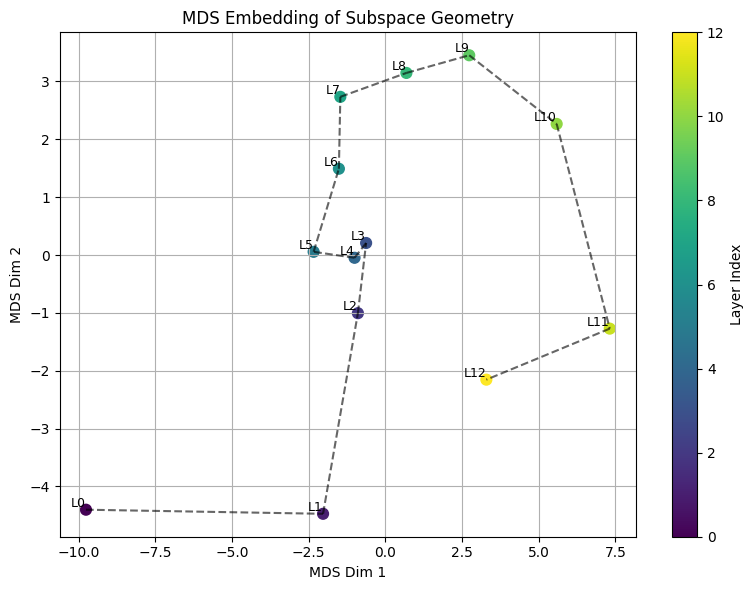

In [14]:
def plot_mds_embedding(angles_between_layers, num_layers):
    dist_matrix = np.zeros((num_layers, num_layers))
    for (i, j), info in angles_between_layers.items():
        dist_matrix[i, j] = info["Θ_total"]
        dist_matrix[j, i] = info["Θ_total"]  # symmetric

    mds = MDS(dissimilarity="precomputed", random_state=42)
    coords = mds.fit_transform(dist_matrix)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(coords[:, 0], coords[:, 1], c=range(num_layers), cmap='viridis', s=60)

    # Plot connecting path: L0 → L1 → L2 ...
    for i in range(num_layers - 1):
        plt.plot([coords[i, 0], coords[i+1, 0]],
                 [coords[i, 1], coords[i+1, 1]],
                 'k--', alpha=0.6)

    # Label each point
    for i in range(num_layers):
        plt.text(coords[i, 0], coords[i, 1], f"L{i}", fontsize=9, ha='right', va='bottom')

    plt.title("MDS Embedding of Subspace Geometry")
    plt.xlabel("MDS Dim 1")
    plt.ylabel("MDS Dim 2")
    plt.colorbar(scatter, label="Layer Index")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_mds_embedding(angles_between_layers, num_layers=len(signal_bases))
